In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

2023-06-10 22:24:35.898199: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-10 22:24:35.900783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 22:24:35.938818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 22:24:35.939640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 22:24:37.216436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens, ann): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [3]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [4]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [5]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [6]:
hidden_neurons = 16

In [7]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 8.0):
    samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens, ann = samp_ann)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = generate_initial_ensembles(4, var_weights, size_ens)
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_weights, size_ens).reshape(-1,1)
    initial_ensembles_for_D2 = generate_initial_ensembles(1, var_weights, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2,1),
                                                       np.expand_dims(initial_ensembles_for_D2_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_L[:,0,:], initial_ensembles_for_D[:,0,:]

In [8]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, ann, weights): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [9]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_both.npy")

In [10]:
y_valid = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")

In [11]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
y_train = y_valid.values[:,1:]

In [13]:
y_train = std_targets.transform(y_train)

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(alogp_bottleneck, y_train, test_size = 0.25, shuffle = True, 
                                                     random_state = 42)

In [16]:
x_train.shape

(719, 64)

In [17]:
smiles_feats_train = x_train[:, :32]

In [18]:
rdkit_feats_train = x_train[:, 32:]

In [19]:
smiles_feats_valid = x_valid[:, :32]
rdkit_feats_valid = x_valid[:, 32:]

In [20]:
# size_ens = 250

In [21]:
def forward_operation(data1, data2, combined_ensembles , size_ens ):
    samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann.count_params()
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4 + 4):(4*params + 4 + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:,:2].sum(1).reshape(-1,1)
    
    model_2 = softmax_weights[:,2:].sum(1).reshape(-1,1)
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    weighted_alogp = data1_out1 + data2_out1
    
    weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles, weighted_alogp, weighted_psa, model_1, model_2

In [22]:
samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)

2023-06-10 22:24:39.395072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-10 22:24:39.395107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: c3101.swan.hcc.unl.edu
2023-06-10 22:24:39.395115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: c3101.swan.hcc.unl.edu
2023-06-10 22:24:39.395225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.85.5
2023-06-10 22:24:39.395246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.85.5
2023-06-10 22:24:39.395253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.85.5


In [23]:
total_weights = 4*(samp_ann.count_params() + 1 + 1 + 1)

In [24]:
total_weights

2192

In [25]:
reduction = 8

In [26]:
size_ens = total_weights//reduction

In [27]:
size_ens

274

In [28]:
X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [29]:
# X_t, initial_ensembles, initial_ensembles_for_weights = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [30]:
initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))

In [31]:
initial_ensembles.shape

(274, 2192)

In [32]:
G_t = [[1, 0, 1, 0], [0, 1, 0, 1]]
G_t = np.array(G_t).T

In [33]:
G_t

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

In [34]:
def get_predictions(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, weighted_psa, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    preds = np.concatenate((weighted_alogp, weighted_psa),-1)
    return preds, w1, w2

In [35]:
# H_t = np.hstack((np.identity(smiles_feats_train.shape[0]), np.zeros((smiles_feats_train.shape[0], samp_ann.count_params() + 1 + 1 + 1))))

In [36]:
# H_t.shape

In [37]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann.count_params() + 1 + 1 + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t,_, _, _, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    # weighted_alogp = np.expand_dims(weighted_alogp,-1)
    # weighted_psa = np.expand_dims(weighted_psa,-1)
    # G_u = np.concatenate((weighted_alogp, weighted_psa), axis = -1)
    # G_u = G_u.transpose((0,2,1))
    # G_u = G_u.reshape(G_u.shape[0], G_u.shape[1]*G_u.shape[2])
    # G_u
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [38]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [39]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [40]:
def get_updated_ensemble(data1, data2, initial_ensembles):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    # all_covs = np.array(all_covs)
    D_plus_cov = D + R_t
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    right_quant = y_train.T.flatten().reshape(-1,1) - G_u.T
    mid_times_right = mid_quant@right_quant
    updated_ensemble = (initial_ensembles.T + mid_times_right)
    return updated_ensemble.T

In [41]:
# initial_ensembles[:, -8:-4].mean(0)

In [42]:
target_dim = 2

In [43]:
# initial_ensembles[:, -4:]

In [44]:
# tf.math.softplus(np.array([0.]).reshape(-1,1))

In [45]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -8:-4]
    cov_part = cov_part.mean(0)
    # variances = tf.math.softplus(cov_part[:2]).numpy()
    variances = cov_part[:2]
    covariances = cov_part[2:]
    base_cov = np.identity(target_dim)
    base_cov[0,0] = variances[0]
    base_cov[1,1] = variances[1]
    base_cov[0,1] = covariances[0]
    base_cov[1,0] = covariances[1]
    
    variances1 = tf.math.softplus(initial_ensembles[:, -4:]).numpy()
    variances1 = variances1.mean(0)
    base_variances = np.identity(target_dim)
    base_variances[0,0] = variances1[0]
    base_variances[1,1] = variances1[2]
    
    final = np.linalg.cholesky(base_cov@base_cov.T + base_variances)
    cov_mat = final@final.T
    cov_mat_final = cov_mat
    # cov_mat_final = cov_mat@cov_mat.T
    
    if is_pos_def(cov_mat_final) != True:
        print("resulting cov matrix is not positive semi definite")
        pass
    
    # print(np.linalg.det(cov_mat_final))
    
    var1 = cov_mat_final[0,0]
    var2 = cov_mat_final[1,1]
    cov = cov_mat_final[1,0]

    n = shape
    
    ul = var1*np.identity(n)
    lr = var2*np.identity(n)
    ur = cov*np.identity(n)
    ll = ur.T    
    
    first_row = np.hstack((ul, ur))
    second_row = np.hstack((ll, lr))
    
    R_t = np.vstack((first_row, second_row))
    
    # R_t = block_diag(*([cov_mat_final] * n))
    
    # R_t = np.linalg.inv(R_t)
    
    return cov_mat_final, R_t
    

In [46]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [47]:
cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

In [48]:
cov_mat_final

array([[1.36664717, 0.01154037],
       [0.01154037, 1.51234777]])

In [49]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [50]:
from joblib import Parallel, delayed

In [51]:
from scipy.linalg import norm

In [52]:
initial_ensembles.shape

(274, 2192)

In [53]:
# from tqdm.notebook import trange

In [54]:
w1_catch = []
w2_catch = []
w1_sd_catch = []
w2_sd_catch = []
weight_norm_mean = []
weight_norm_sd = []
for i in range(0,10000):
    
    initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    G_u_train, w1, w2 = get_predictions(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    
    w1_catch.append(w1.mean())
    w1_sd_catch.append(w1.std())
    
    w2_catch.append(w2.mean())
    w2_sd_catch.append(w2.std())  
    
    print("Epoch" + str(i+1))
    
    
    print("Averaging Weight")
    print([w1.mean(), w1.std()])
    # print(w2.mean(), w2.std())
    
    # G_u_train = get_targets_with_weights(smiles_feats_train, rdkit_feats_train, initial_ensembles, size_ens = size_ens)
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
    G_u_train = np.array(catch)
    
    y_train_cur = std_targets.inverse_transform(y_train)
    
    li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_train = ui_train - li_train
    avg_width_train = width_train.mean(0)
    
    ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
    coverage_train= ind_train.mean(0)
    
    averaged_targets_train = G_u_train.mean(0)
    rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))
    # print(rmse_train, coverage_train, avg_width_train)
    
    G_u_test, _, _ = get_predictions(smiles_feats_valid, rdkit_feats_valid, initial_ensembles)
    
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))
    G_u_test = np.array(catch)
    
    y_valid_cur = std_targets.inverse_transform(y_valid)    
    
    li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_test = ui_test - li_test
    avg_width_test = width_test.mean(0)
    
    ind_test = (y_valid_cur >= li_test) & (y_valid_cur <= ui_test)
    coverage_test= ind_test.mean(0)
    
    averaged_targets_test = G_u_test.mean(0)
    rmse_test = np.sqrt(((y_valid_cur -averaged_targets_test)**2).mean(0))    
    
    weight_norms = np.array(norm(initial_ensembles, ord = 2, axis = 1))
    weight_norm_mean.append(weight_norms.mean())
    weight_norm_sd.append(weight_norms.std())
    
   
    print("Weight Norms")
    print([weight_norms.mean(), weight_norms.std()])
    
    
    if np.mean(coverage_train < 0.95) == 1:
        break
        
    cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)
    
    print("about_R_t")
    print(np.diag(cov_mat_final), cov_mat_final[0,1])
    
    print("RMSEs, Coverages, and Widths")
    print(rmse_test, coverage_test, avg_width_test)
    
    print("\n")

Epoch1
Averaging Weight
[0.5302945717745011, 0.34890049156446185]
Weight Norms
[111.81396923442372, 14.16518606577367]
about_R_t
[1.17010835 1.42177419] 0.01236565119023346
RMSEs, Coverages, and Widths
[  6.7784586  611.90863203] [1. 1.] [  975.73108479 23027.59048314]


Epoch2
Averaging Weight
[0.6032382264834777, 0.3172760329123329]
Weight Norms
[99.61706988581979, 18.332684013850034]
about_R_t
[1.08014572 1.3684112 ] 0.00856425148614221
RMSEs, Coverages, and Widths
[  5.5119968  306.96364025] [1. 1.] [  577.90291449 13652.10491128]


Epoch3
Averaging Weight
[0.6975227100659972, 0.27165451351972086]
Weight Norms
[90.68814223671389, 20.952588870384684]
about_R_t
[1.03690092 1.25054588] -0.023568127995974353
RMSEs, Coverages, and Widths
[  5.03620532 213.18710628] [1. 1.] [ 358.37446565 7801.0318162 ]


Epoch4
Averaging Weight
[0.761283085478832, 0.22057378757162407]
Weight Norms
[82.90902219289077, 21.914718277758755]
about_R_t
[0.8988556  1.29844804] -0.049298018377527446
RMSEs, Cove


KeyboardInterrupt



In [55]:
G_u_test.shape

(274, 240, 2)

In [56]:
import random

In [57]:
random_idx = random.sample(range(y_valid_cur.shape[0]), k = 8)

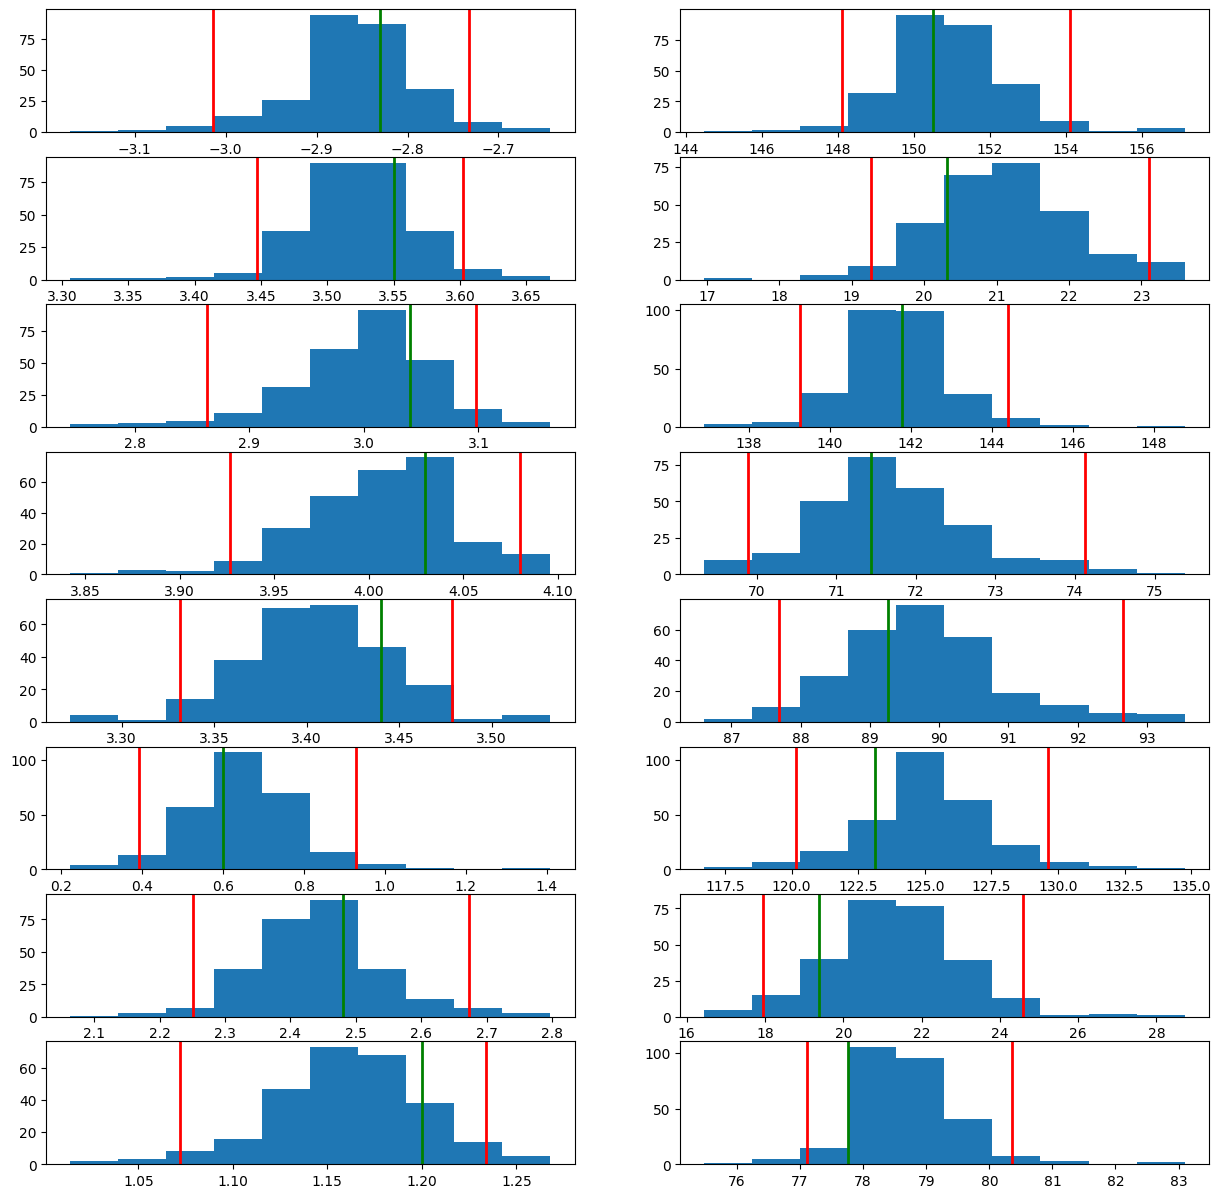

In [58]:
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
# axs = axs.ravel()
# counter = 0
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_valid_cur[i,:]
    preds = G_u_test[:, i,:]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0,:]
    uis = percts[1,:]
    
    
    axs[idx, 0].hist(preds[:,0])
    axs[idx, 0].axvline(truth[0], color='green', linewidth=2)
    axs[idx, 0].axvline(lis[0], color='red', linewidth=2)
    axs[idx, 0].axvline(uis[0], color='red', linewidth=2)
    
    axs[idx, 1].hist(preds[:,1])
    axs[idx, 1].axvline(truth[1], color='green', linewidth=2)
    axs[idx, 1].axvline(lis[1], color='red', linewidth=2)
    axs[idx, 1].axvline(uis[1], color='red', linewidth=2)
    
    # counter+=2
    # print(counter)
    
    # plt.show()
plt.savefig('prediction_intervals.png', bbox_inches='tight')

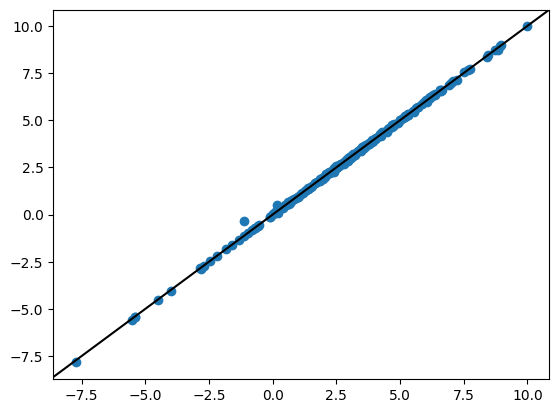

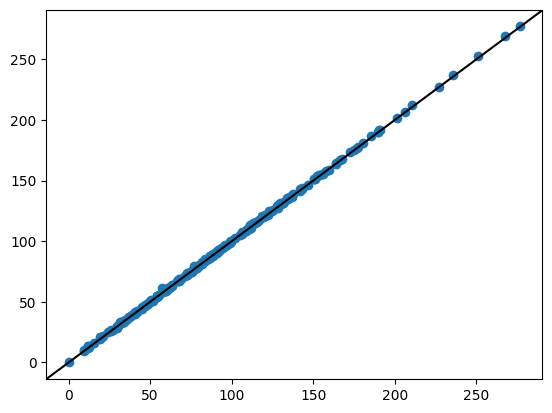

In [59]:
plt.scatter(y_valid_cur[:, 0], averaged_targets_test[:,0])
plt.axline((0,0), slope = 1, c= "black")
plt.show()
plt.scatter(y_valid_cur[:,1], averaged_targets_test[:, 1])
plt.axline((0,0), slope = 1, c= "black")
plt.show()

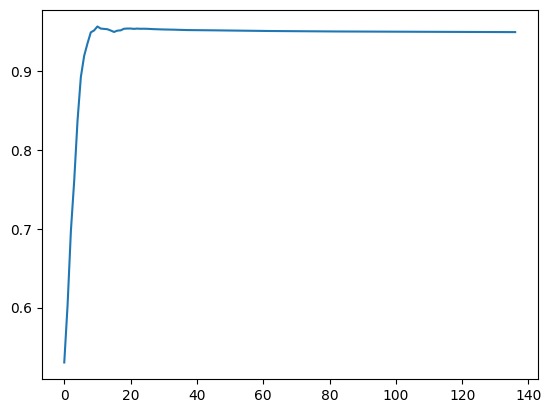

In [60]:
plt.plot(w1_catch)
plt.show()

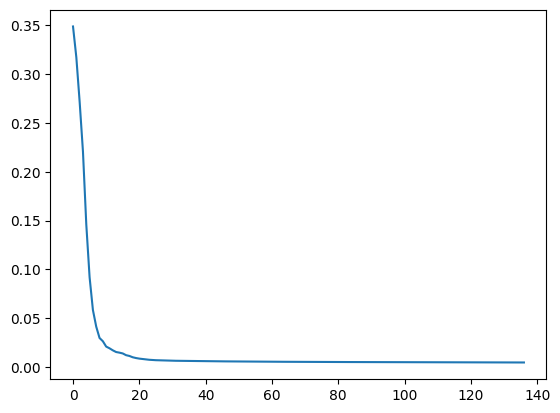

In [61]:
plt.plot(w1_sd_catch)
plt.show()


<ErrorbarContainer object of 3 artists>

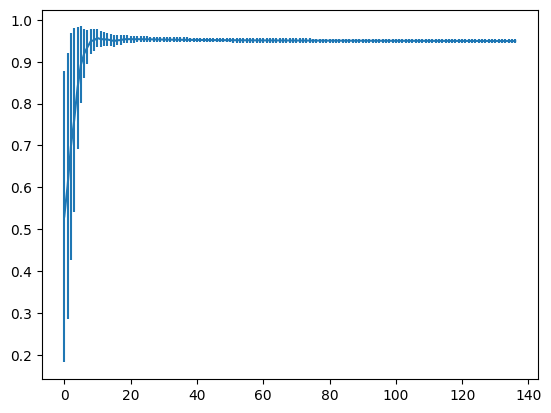

In [62]:
plt.errorbar(range(0, len(w1_catch)), w1_catch, w1_sd_catch)

<ErrorbarContainer object of 3 artists>

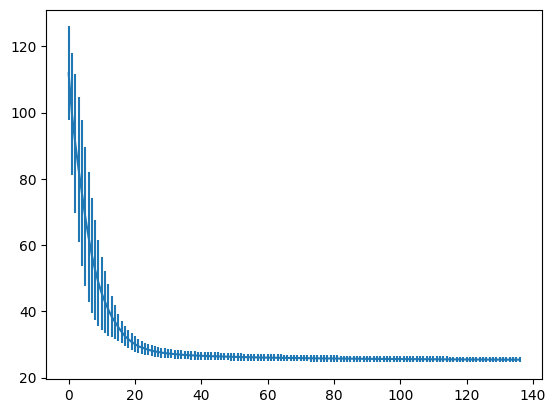

In [63]:
plt.errorbar(range(0, len(weight_norm_mean)), weight_norm_mean, weight_norm_sd)

In [64]:
cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

In [65]:
# R_t

In [66]:
cov_mat_final

array([[ 1.51727023, -0.40662653],
       [-0.40662653,  0.94989929]])

In [67]:
np.cov(y_train.T)

array([[ 2.00883439, -0.73234091],
       [-0.73234091,  1.65672997]])